In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from LearningAlgorithms import ClassificationAlgorithms
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

In [26]:
# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

# Load the dataset

In [27]:
df = pd.read_pickle("../../data/interim/03_data_features.pkl")


# Create a training and test set

In [28]:
df_train = df.drop(["participant", "category", "set"], axis = 1)
X = df_train.drop("label", axis = 1)
y = df_train["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

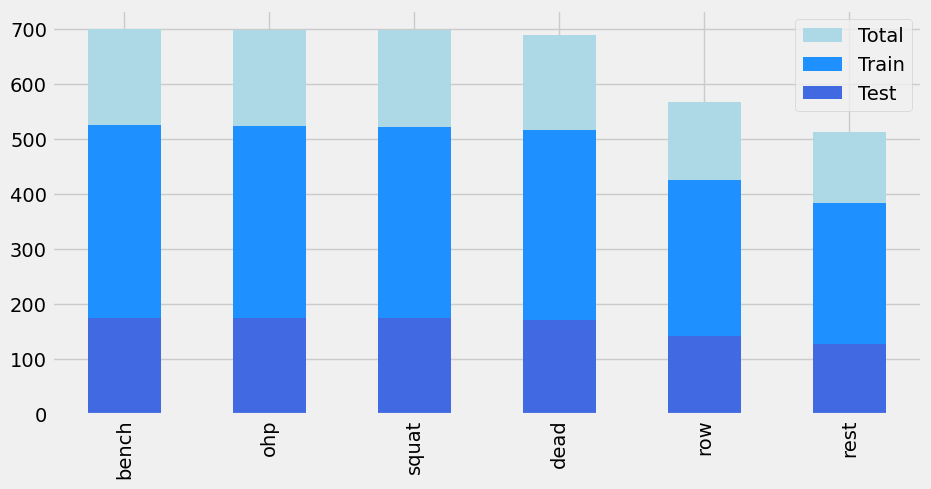

In [29]:
#distribution des dataset de traind et test 
fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(
kind = "bar", ax=ax, color="Lightblue", label= "Total")
y_train.value_counts().plot(kind = "bar", ax=ax, color="dodgerblue", label = "Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label = "Test")
plt.legend()
plt.show()
#on remarque qu'on a une distribustion égale

# Split feature subsets

In [30]:
basic_features = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"] 
square_features = ["acc_r","gyr_r"]
pca_features = ["pca_1", "pca_2", "pca_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
freq_features = [f for f in df_train.columns if (("_freq" in f) or ("_pse" in f))]
cluster_features =["cluster"]

print("Basic features:", len(basic_features)) 
print("Square features:", len(square_features))
print("PCA features:", len(pca_features)) 
print("Time features:", len(time_features)) 
print("Frequency features:", len(freq_features)) 
print("Cluster features:", len(cluster_features))

Basic features: 6
Square features: 2
PCA features: 3
Time features: 16
Frequency features: 88
Cluster features: 1


In [31]:
#these combinaison i will  use them later!! just be patient
feature_set_1 = list(set(basic_features))
feature_set_2 = list(set(basic_features + square_features + pca_features))
feature_set_3 = list(set(feature_set_2 +  time_features ))
feature_set_4 = list(set(feature_set_3 + freq_features + cluster_features))
learner = ClassificationAlgorithms()
max_features = 10

# Perform forward feature selection using simple decision tree

In [32]:
learner = ClassificationAlgorithms()

In [ ]:
learner = ClassificationAlgorithms()
max_features = 10
selected_features, ordered_features, ordered_scores = learner.forward_selection(max_features, X_train, y_train)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, max_features + 1, 1), ordered_scores)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, max_features + 1, 1))
plt.show()

0
1


In [33]:
#save them here in case we need them; as u can see they are all freq from the fourier transformation step we did before
selected_features = ['acc_z_freq_0.0_Hz_ws_14',
 'acc_x_freq_0.0_Hz_ws_14',
 'duration',
 'gyr_r_temp_mean_ws_5',
 'acc_y_temp_mean_ws_5',
 'pca_2',
 'gyr_x_temp_std_ws_5',
 'acc_z_freq_2.143_Hz_ws_14',
 'pca_1',
 'gyr_x_freq_2.5_Hz_ws_14']

ordered_scores = [
    0.885556704584626,
    0.9903481558083419,
    0.9989658738366081,
    0.9993105825577387,
    0.9996552912788693,
    0.9996552912788693,
    0.9996552912788693,
    0.9996552912788693,
    0.9996552912788693,
    0.9996552912788693
]

# Grid search for best hyperparameters and model selection

In [34]:
possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
    selected_features
]
feature_names = [
    "Feature Set 1",
    "Feature Set 2",
    "Feature Set 3",
    "Feature Set 4",
    "Selected Features"
]

iterations = 1
score_df = pd.DataFrame()


In [35]:
#Train the 5 models
for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0
	Training random forest, 0
	Training KNN


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

	Training decision tree
	Training naive bayes


In [30]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# Ignorer les avertissements de convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.resetwarnings()

print("Feature set:",selected_features )
selected_train_X = X_train[possible_feature_sets[4]]
selected_test_X = X_test[possible_feature_sets[4]]

# First run non deterministic classifiers to average their score.
performance_test_nn = 0
performance_test_rf = 0

print("\tTraining decision tree")
(
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
performance_test_dt = accuracy_score(y_test, class_test_y)

performance_test_nn = performance_test_nn
performance_test_rf = performance_test_rf
   

Feature set: ['acc_z_freq_0.0_Hz_ws_14', 'acc_x_freq_0.0_Hz_ws_14', 'duration', 'gyr_r_temp_mean_ws_5', 'acc_y_temp_mean_ws_5', 'pca_2', 'gyr_x_temp_std_ws_5', 'acc_z_freq_2.143_Hz_ws_14', 'pca_1', 'gyr_x_freq_2.5_Hz_ws_14']
	Training decision tree


# Create a grouped bar plot to compare the results

In [36]:
score_df

,model,feature_set,accuracy
0,NN,Feature Set 1,0.940021
1,RF,Feature Set 1,0.960703
2,KNN,Feature Set 1,0.792141
3,DT,Feature Set 1,0.926577
4,NB,Feature Set 1,0.854188
0,NN,Feature Set 2,0.934850
1,RF,Feature Set 2,0.956567
2,KNN,Feature Set 2,0.789038
3,DT,Feature Set 2,0.927611
4,NB,Feature Set 2,0.863495


# Create a grouped bar plot to compare the results

In [37]:
score_df.sort_values(by= "accuracy", ascending = False, inplace = True) 

In [38]:
score_df

,model,feature_set,accuracy
1,RF,Selected Features,0.996898
0,NN,Selected Features,0.994829
3,DT,Selected Features,0.992761
1,RF,Feature Set 4,0.992761
0,NN,Feature Set 4,0.991727
0,NN,Feature Set 3,0.987590
3,DT,Feature Set 4,0.986556
1,RF,Feature Set 3,0.985522
2,KNN,Feature Set 4,0.972079
4,NB,Feature Set 4,0.963806


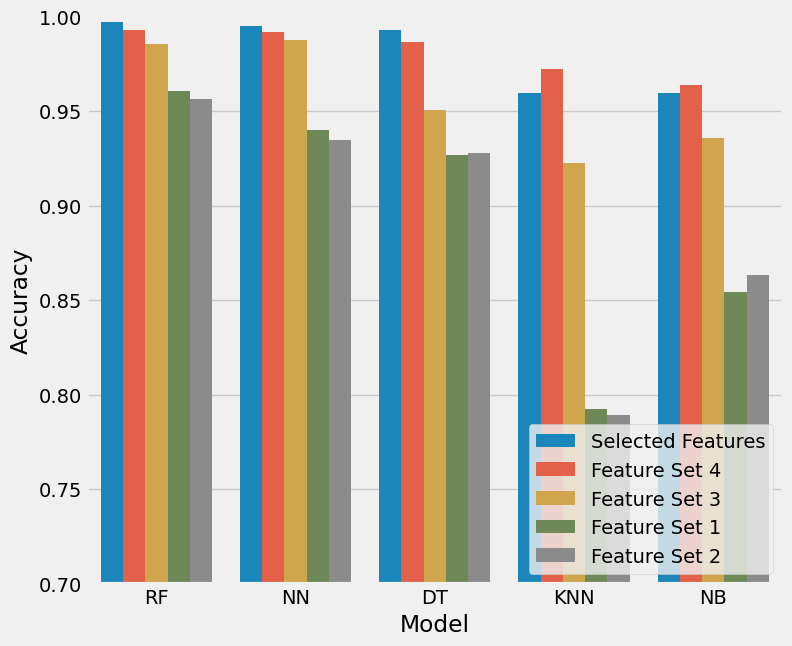

In [39]:
plt.figure(figsize=(8,7))
sns.barplot(x="model", y="accuracy", hue="feature_set", data = score_df)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.legend(loc="lower right")
plt.show()

# Select best model and evaluate results

In [42]:
#LETS train the random forest again on the training data with the feature_set_4 :
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.random_forest(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=True
)

In [43]:
accuracy = accuracy_score(y_test, class_test_y)
accuracy

0.9906928645294726

In [44]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels = classes)
cm

array([[173,   0,   2,   0,   0,   0],
       [  0, 172,   0,   0,   0,   0],
       [  6,   0, 169,   0,   0,   0],
       [  0,   0,   1, 127,   0,   0],
       [  0,   0,   0,   0, 142,   0],
       [  0,   0,   0,   0,   0, 175]], dtype=int64)

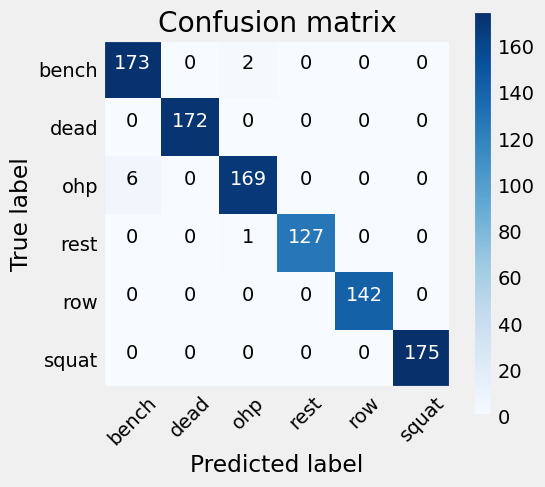

In [47]:
# create confusion matrix for cm
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

# Select train and test data based on participant

In [25]:
participant_df = df.drop(["set", "category"], axis =1)

<function matplotlib.pyplot.show(close=None, block=None)>

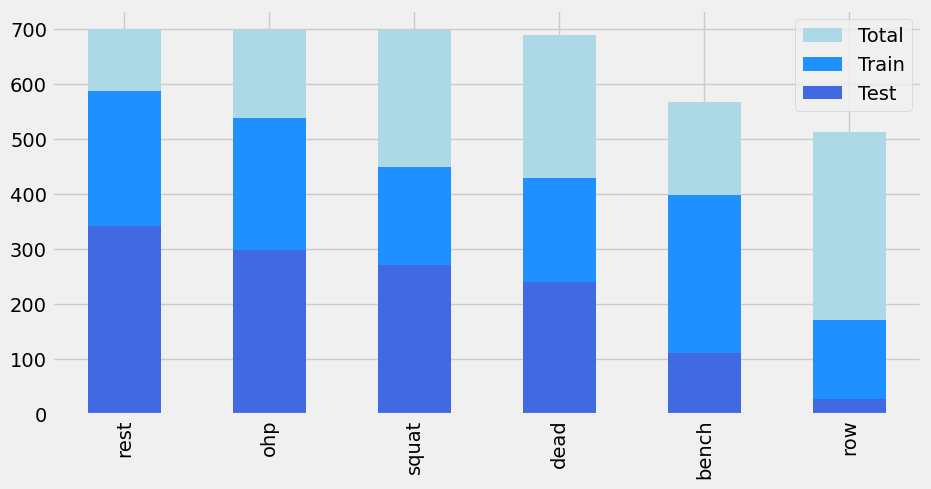

In [48]:
#splitting data 
#training data without the participant A's infos and the label
participant_df = df.drop(["set", "category"], axis =1)
X_train = participant_df[participant_df["participant"] != "A"].drop(["label"], axis = 1)
y_train = participant_df[participant_df["participant"] != "A"]["label"]

#test data with the participant A's infos on the label
X_test = participant_df[participant_df["participant"] == "A"].drop(["label"], axis = 1)
y_test = participant_df[participant_df["participant"] == "A"]["label"]

#drop the the column particiant we dont need it 
X_train = X_train.drop(["participant"], axis = 1)
X_test = X_test.drop(["participant"], axis = 1)

#see the distribution of X_train and y_train
fig, ax = plt.subplots(figsize=(10,5)) 
df_train["label"].value_counts().plot(
kind="bar", ax=ax, color="Lightblue", label="Total")
y_train.value_counts().plot(kind = "bar", ax = ax, color="dodgerblue", label="Train") 
y_test.value_counts().plot(kind = "bar", ax = ax, color="royalblue", label="Test")
plt.legend()
plt.show

# Use best model again and evaluate results

In [ ]:
#using the X_train and y_train splited based on the participant , so that the algorithm will be flexible with 
#every participant that goes to the gym and does exercices

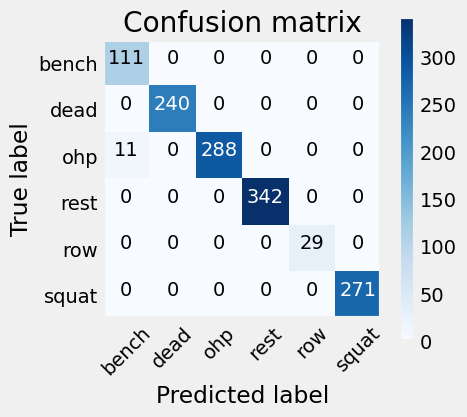

In [ ]:
#LETS train the random forest again on the training data based on participant with the feature_set_4 groups of columns :
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.random_forest(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=True
)
accuracy = accuracy_score(y_test, class_test_y)
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels = classes)
# create confusion matrix for cm
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

In [ ]:
accuracy
#this is an exciting approach , the accuracy still ahead even if we split the data based on participant 
#so this algorithme will suit every participant whoever is 

0.9914860681114551

# Try a complex model with the selected features

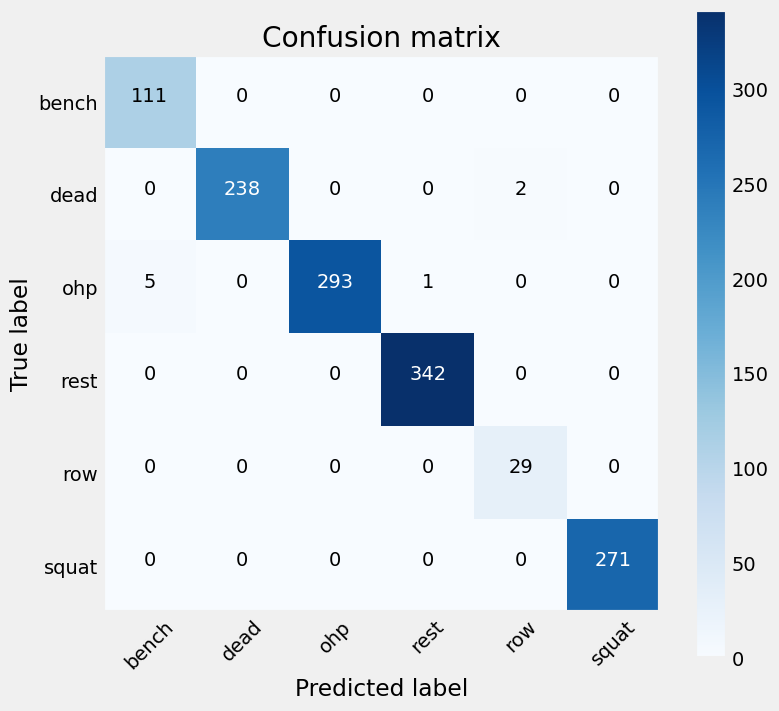

In [52]:
#this model applied with the selected feature performe less  than the feature_set_4
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.feedforward_neural_network(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=False
)
accuracy = accuracy_score(y_test, class_test_y)
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels = classes)
# create confusion matrix for cm
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()